In [1]:
%matplotlib inline

from time import time
import itertools as it

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import euclidean_distances
from scipy.sparse import csc_matrix
from tqdm import tqdm
import gudhi
import galois

In [2]:
counts_M = pd.read_csv("peyers_data/counts_M.csv", index_col=0)
normCounts_M = pd.read_csv("peyers_data/normCounts_M.csv", index_col=0)
md_M = pd.read_csv("peyers_data/md_M.txt", index_col=0,
                  sep="\t")

counts_tissue = pd.read_csv("peyers_data/counts_tissue.csv", index_col=0)
normCounts_tissue = pd.read_csv("peyers_data/normCounts_tissue.csv",
                                index_col=0)
md_tissue = pd.read_csv("peyers_data/md_tissue.txt", index_col=0,
                       sep="\t")

In [3]:
X_M = counts_M.to_numpy().T
X_M_norm = normCounts_M.to_numpy().T
X_tissue = counts_tissue.to_numpy().T
X_tissue_norm = normCounts_tissue.to_numpy().T

logX_M = np.log(X_M + 1)
logX_M_norm = np.log(X_M_norm + 1)
logX_tissue = np.log(X_tissue + 1)
logX_tissue_norm = np.log(X_tissue_norm + 1)

dist_mat_M = euclidean_distances(logX_M)
dist_mat_M_norm = euclidean_distances(logX_M_norm)
dist_mat_tissue = euclidean_distances(logX_tissue)
dist_mat_tissue_norm = euclidean_distances(logX_tissue_norm)

In [4]:
def isolate_persistence_pairs(pps, dim=1):
    dp1 = dim + 1
    i_pps = []
    for sower, reaper in pps:
        if len(sower) == dp1:
            i_pps.append((sower, reaper))
    return i_pps

def birth_death_from_persistence_intervals(st, intrv):
    births = []
    deaths = []
    for birth, death in intrv:
        births.append(birth)
        deaths.append(death)
    return births, deaths

In [5]:
def get_most_variable_genes(X, p):
    var_vec = np.var(X, axis=0)
    ind_list = list(range(len(var_vec)))
    ind_list.sort(key=lambda x: var_vec[x], reverse=True)
    top_inds = ind_list[:p]
    return top_inds

In [6]:
p = 3000

top_inds_p = get_most_variable_genes(X_tissue_norm, p)
X_tissue_norm_p = X_tissue_norm[:, top_inds_p]
dist_mat_p = euclidean_distances(X_tissue_norm_p, X_tissue_norm_p)

pca = PCA(n_components=5)
X_pca = pca.fit_transform(X_tissue_norm)

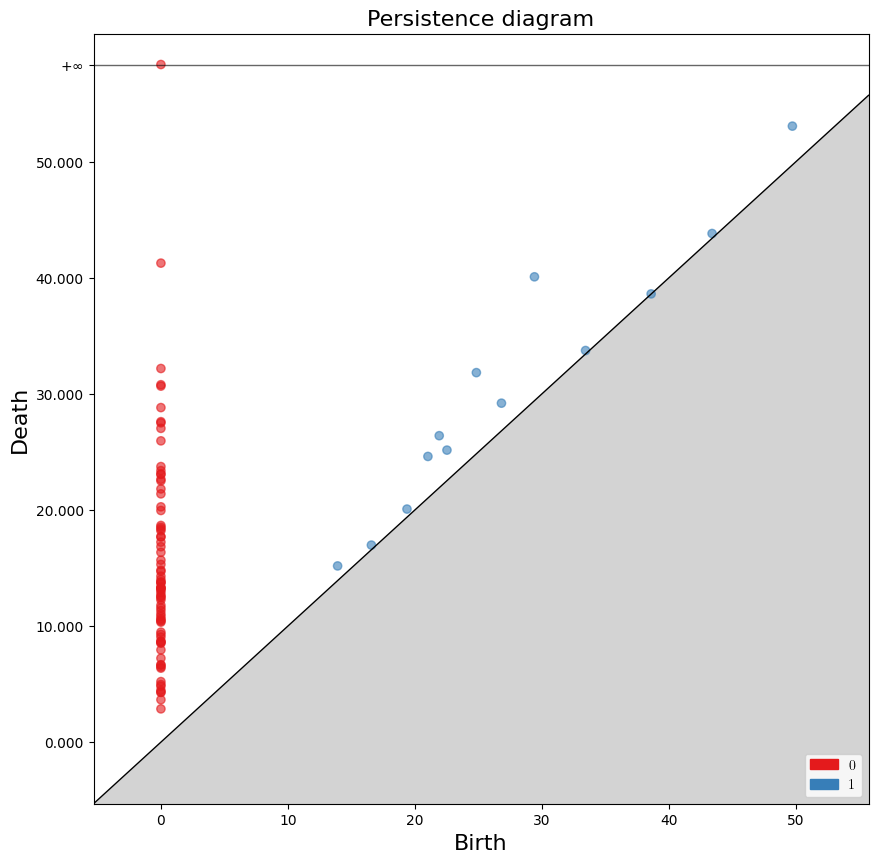

In [7]:
rips_p = gudhi.RipsComplex(points=X_pca)
st_p = rips_p.create_simplex_tree(max_dimension=2)
diag_p = st_p.persistence(homology_coeff_field=2, min_persistence=0)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot()
gudhi.plot_persistence_diagram(diag_p, axes=ax)

plt.show()

In [8]:
pps_p = st_p.persistence_pairs()
i_pps_p = isolate_persistence_pairs(pps_p)
intrv_p = st_p.persistence_intervals_in_dimension(1)

# births_p, deaths_p = birth_death_from_persistence_pairs(st_p, i_pps_p)
births_p, deaths_p = birth_death_from_persistence_intervals(st_p, intrv_p)
lifetimes_p = [(death - birth) for birth, death in zip(births_p, deaths_p)]

i_pp_inds_p = list(range(len(i_pps_p)))
i_pp_inds_p.sort(key=lambda x: lifetimes_p[x], reverse=True)

In [9]:
pca = PCA(n_components=3)
pca.fit(X_tissue_norm_p)

Y = pca.transform(X_tissue_norm_p)

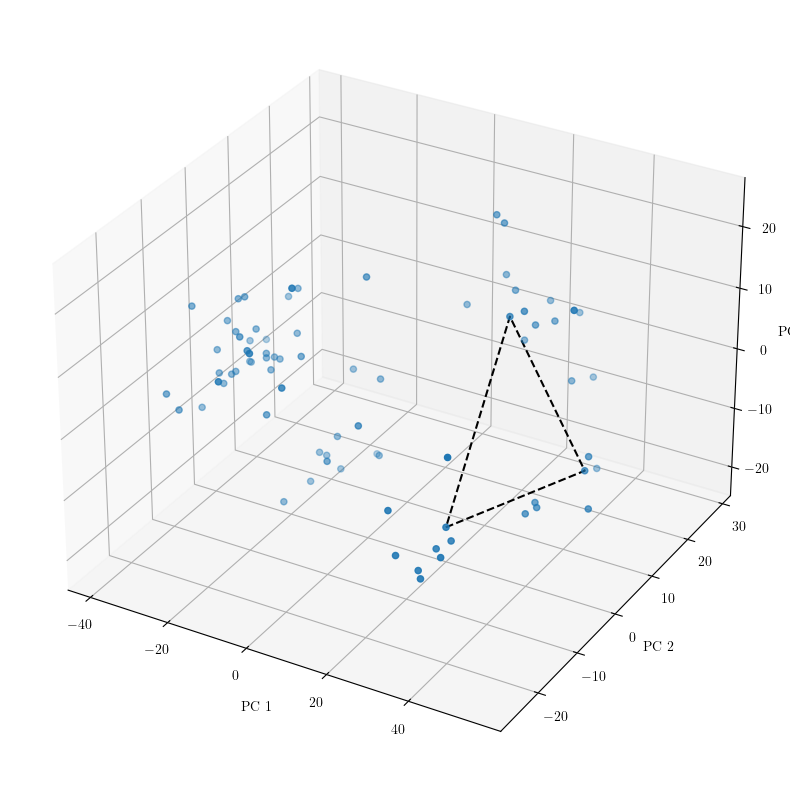

In [10]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection="3d")

ax.scatter(Y[:, 0], Y[:, 1],
             Y[:, 2])
for ind in i_pp_inds_p[:1]:
    sower, reaper = i_pps_p[ind]
    xs = [Y[sub_ind, 0] for sub_ind in reaper]
    xs = xs + [Y[reaper[0], 0]]
    ys = [Y[sub_ind, 1] for sub_ind in reaper]
    ys = ys + [Y[reaper[0], 1]]
    zs = [Y[sub_ind, 2] for sub_ind in reaper]
    zs = zs + [Y[reaper[0], 2]]
    ax.plot(xs, ys, zs, color="k", linestyle="dashed")

ax.set_xlabel("PC 1")
ax.set_ylabel("PC 2")
ax.set_zlabel("PC 3")
plt.show()

In [11]:
n_verts = st_p.num_vertices()
vertices = list(range(n_verts))
edges_full = []
for j in tqdm(range(n_verts)):
    for k in range(j+1, n_verts):
        edges_full.append((j, k))
tris_full = []
for j in tqdm(range(n_verts)):
    for k in range(j+1, n_verts):
        for l in range(k+1, n_verts):
            tris_full.append((j, k, l))
            
edges_full_dict = dict([(edge, j) for j, edge in enumerate(edges_full)])
tris_full_dict = dict([(tri, j) for j, tri in enumerate(tris_full)])

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 6205.30it/s]


In [12]:
filt_max = births_p[i_pp_inds_p[0]]
filt_max += 5

edges_filt = []
tris_filt = []
for simp, filt in st_p.get_filtration():
    if filt <= filt_max:
        simp.sort()
        if len(simp) == 2:
            edges_filt.append(tuple(simp))
        if len(simp) == 3:
            tris_filt.append(tuple(simp))

In [13]:
Z2 = galois.GF(2)

d_1_0_full = Z2.Zeros((n_verts, len(edges_full)))
for j, edge in enumerate(edges_full):
    for ind in edge:
        d_1_0_full[ind, j] = 1
        
print("Computing nullspace...")
start = time()
d_1_0_null = d_1_0_full.null_space()
print("Time elapsed: "+str(time() - start))

Computing nullspace...
Time elapsed: 9.186189413070679


In [14]:
d_2_1_full = Z2.Zeros((len(edges_full), len(tris_full)))
for j, tri in enumerate(tris_full):
    for ind in tri:
        edge = tuple([otra for otra in tri if otra != ind])
        d_2_1_full[edges_full_dict[edge], j] = 1

In [15]:
edge_basis = Z2.Zeros((len(edges_full), len(edges_filt)))
for j, edge in enumerate(edges_filt):
    edge_basis[edges_full_dict[edge], j] = 1
    
tri_basis = Z2.Zeros((len(tris_full), len(tris_filt)))
for j, tri in enumerate(tris_filt):
    tri_basis[tris_full_dict[tri], j] = 1

In [16]:
d_1_0_reduced = d_1_0_full @ edge_basis
d_1_0_nullred = d_1_0_reduced.null_space()

print(d_1_0_nullred.shape)

(546, 622)


In [17]:
#Sparsify things
edge_basis_transpose_numpy = edge_basis.transpose().__array__()
left = csc_matrix(edge_basis_transpose_numpy)
del edge_basis_transpose_numpy
middle_pre = d_2_1_full.__array__()
middle = csc_matrix(middle_pre)
del middle_pre
right_pre = tri_basis.__array__()
right = csc_matrix(right_pre)
del right_pre
d_2_1_reduced_pre = left @ middle @ right
d_2_1_reduced = Z2(d_2_1_reduced_pre.toarray())
del d_2_1_reduced_pre
red_space = d_2_1_reduced.column_space()

In [18]:
cols_to_keep = []
for j in tqdm(range(d_1_0_nullred.shape[0])):
    col = d_1_0_nullred[j, :]
    new_mat = np.hstack([col.reshape(-1, 1), d_2_1_reduced])
    if new_mat.column_space().shape[0] != red_space.shape[0]:
        cols_to_keep.append(col)

print(cols_to_keep)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 546/546 [01:07<00:00,  8.08it/s]

[GF([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [19]:
print(len(cols_to_keep))
print(type(cols_to_keep))
print(type(cols_to_keep[0]))

8
<class 'list'>
<class 'galois.GF(2)'>


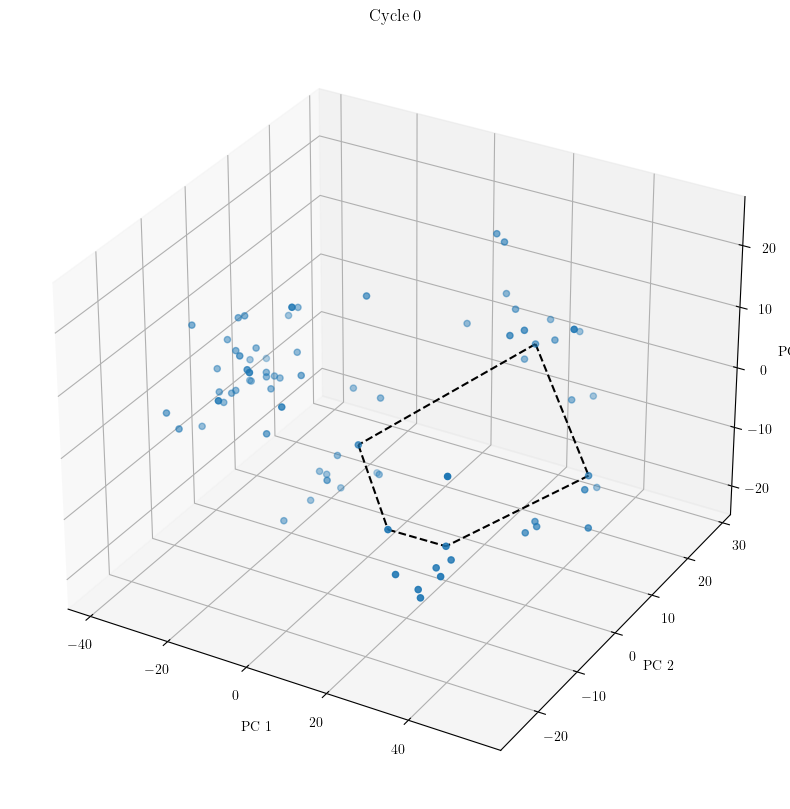

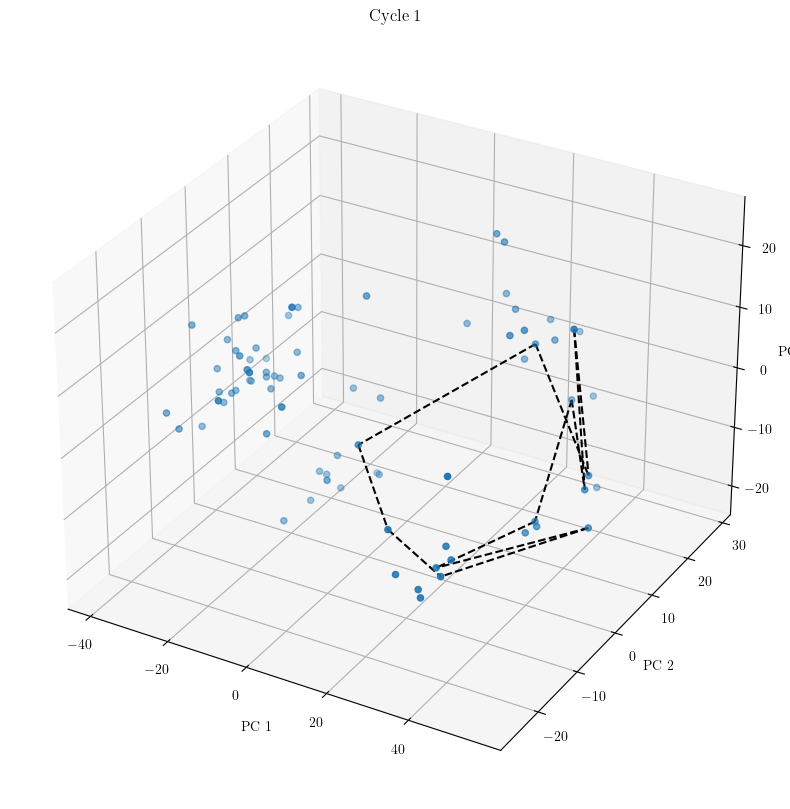

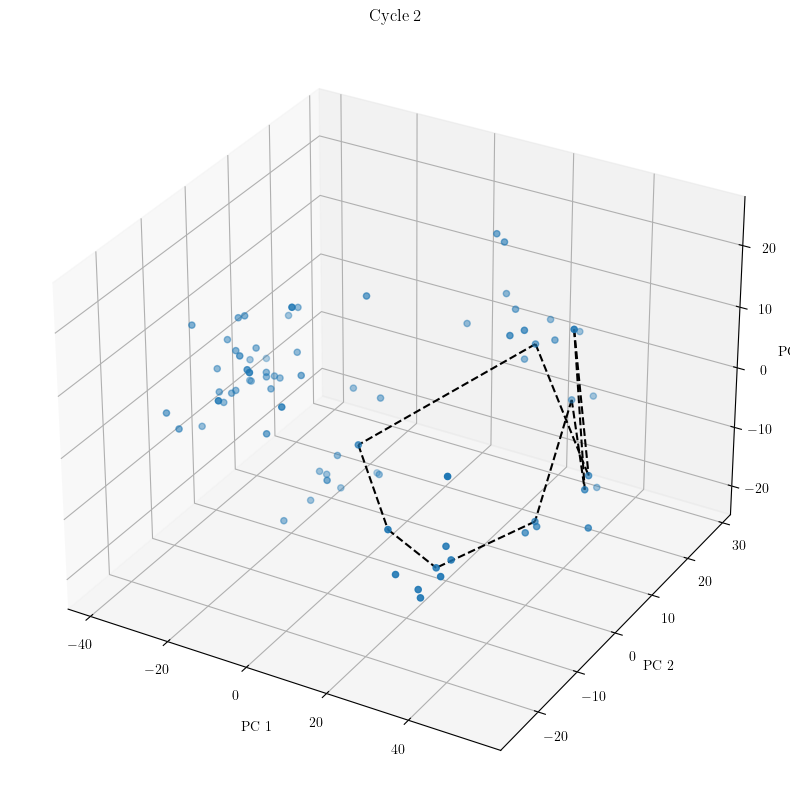

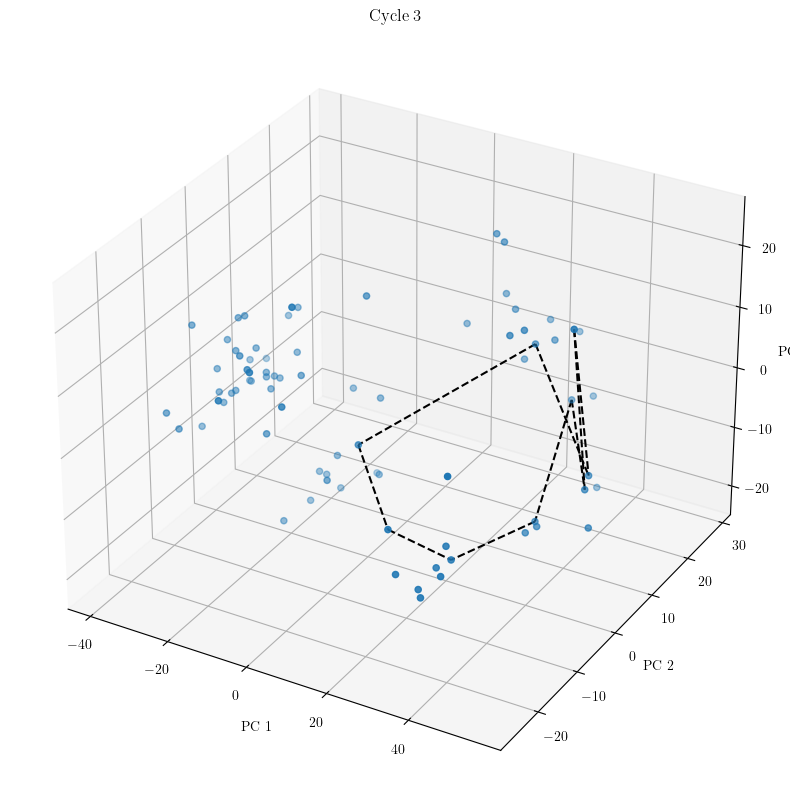

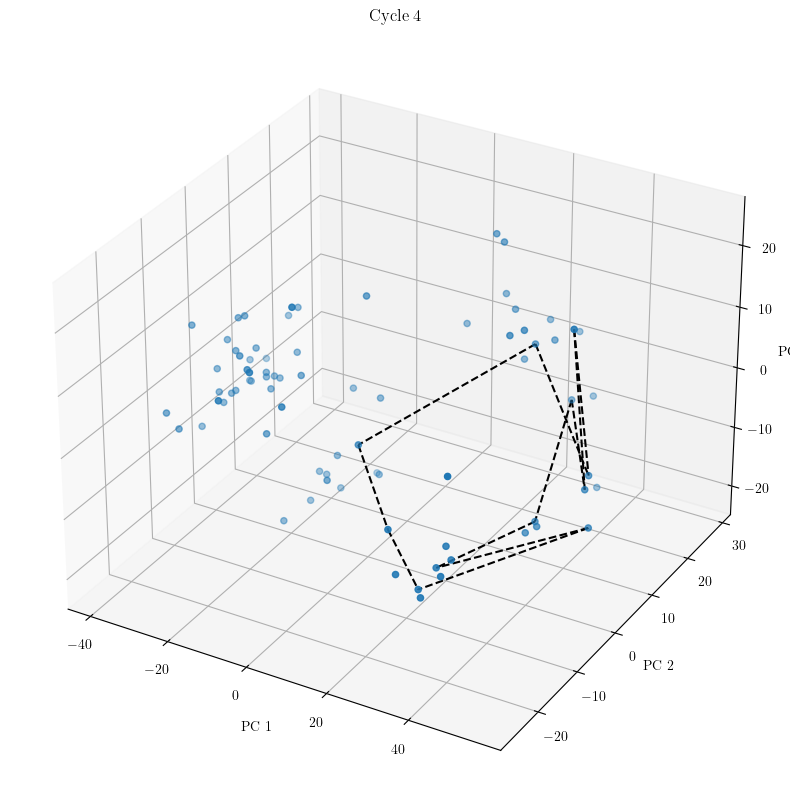

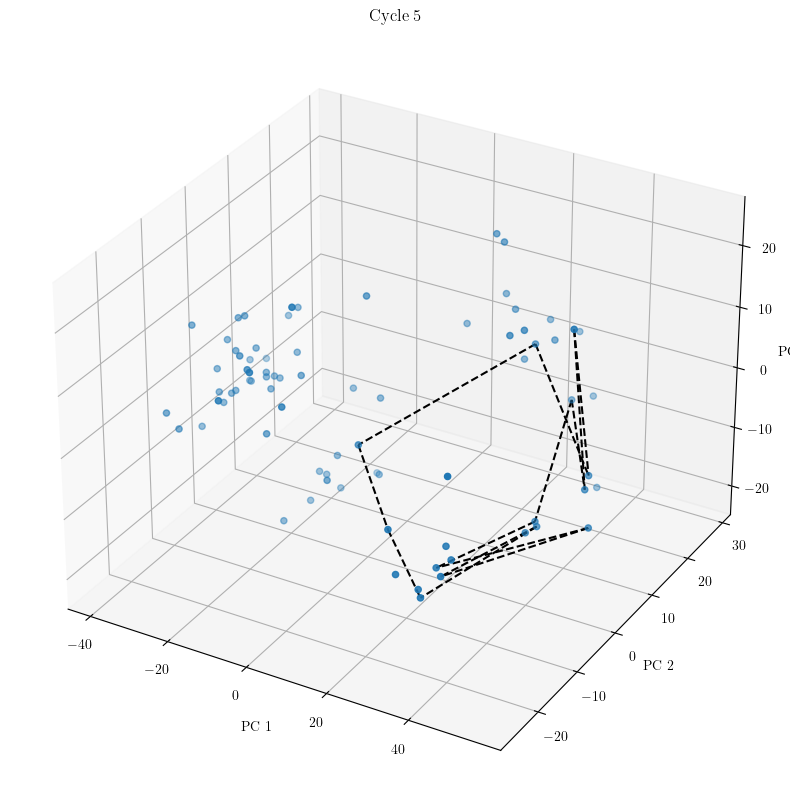

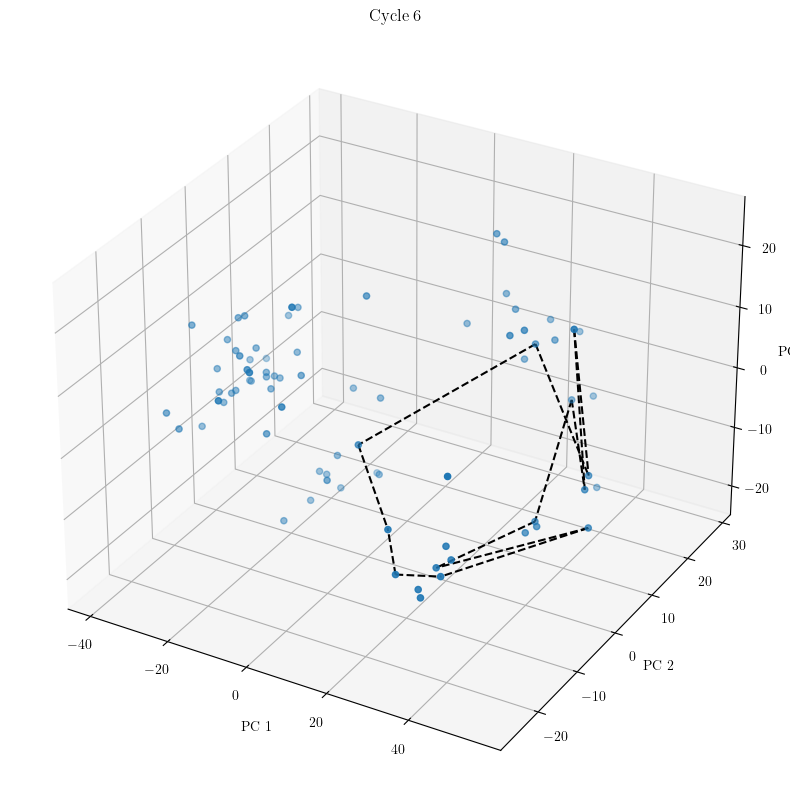

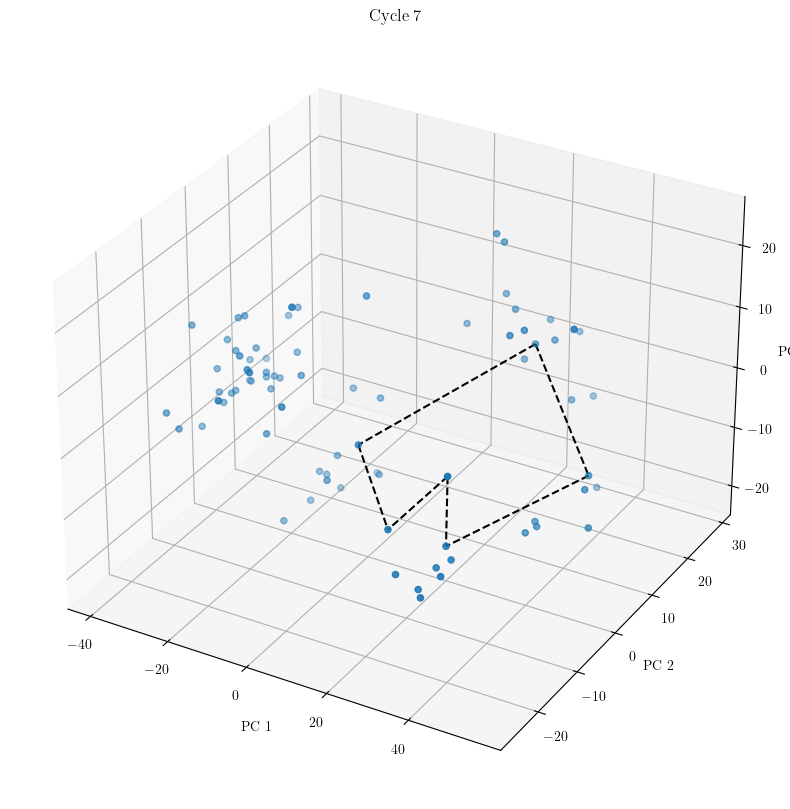

In [20]:
for j, col in enumerate(cols_to_keep):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(projection="3d")

    ax.scatter(Y[:, 0], Y[:, 1],
             Y[:, 2])
    
    for k, val in enumerate(col):
        if val:
            edge = edges_filt[k]
            xx = [Y[ind, 0] for ind in edge]
            yy = [Y[ind, 1] for ind in edge]
            zz = [Y[ind, 2] for ind in edge]
            ax.plot(xx, yy, zz, color="k",
                   linestyle="dashed")
    
    ax.set_xlabel("PC 1")
    ax.set_ylabel("PC 2")
    ax.set_zlabel("PC 3")
    
    ax.set_title("Cycle "+str(j))

plt.show()

bitstrings = list(it.product([0, 1], repeat=len(cols_to_keep)))

n_rows = 2**len(cols_to_keep)
for j, bitstring in enumerate(bitstrings):
    vec = Z2.Zeros(cols_to_keep[0].shape)
    for jj, bit in enumerate(bitstring):
        if bit:
            vec += cols_to_keep[jj]
    #print(vec)

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(projection="3d")

    ax.scatter(Y[:, 0], Y[:, 1],
             Y[:, 2])
    
    for k, val in enumerate(vec):
        if val:
            edge = edges_filt[k]
            xx = [Y[ind, 0] for ind in edge]
            yy = [Y[ind, 1] for ind in edge]
            zz = [Y[ind, 2] for ind in edge]
            ax.plot(xx, yy, zz, color="k",
                   linestyle="dashed")
    
    ax.set_xlabel("PC 1")
    ax.set_ylabel("PC 2")
    ax.set_zlabel("PC 3")
    
    ax.set_title("Cycle "+str(j))
    
    fig.savefig("exhaustion_ultra/"+str(j)+".png")
    plt.close(fig)

In [21]:
for j, col in enumerate(cols_to_keep):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(projection="3d")

    ax.scatter(Y[:, 0], Y[:, 1],
             Y[:, 2])
    
    for k, val in enumerate(col):
        if val:
            edge = edges_filt[k]
            xx = [Y[ind, 0] for ind in edge]
            yy = [Y[ind, 1] for ind in edge]
            zz = [Y[ind, 2] for ind in edge]
            ax.plot(xx, yy, zz, color="k",
                   linestyle="dashed")
    
    ax.set_xlabel("PC 1")
    ax.set_ylabel("PC 2")
    ax.set_zlabel("PC 3")
    
    ax.set_title("Cycle "+str(j))
    fig.savefig("sad_boi_ultra/"+str(j)+".png")
    plt.close(fig)